In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".10"

In [2]:
import pandas as pd
from model import Brain
from submodels import factories
import matplotlib.pyplot as plt
import pandas as pd
from itertools import accumulate
import numpy as np
from collections import defaultdict
import re

from lib.sde.grn.grn4 import GRNMain4 as GRNMain
from lib.sde.cell.cell4 import Cell4 as Cell
from lib.sde.mutate import mutate_grn4 as mutate_grn
from lib.ga.utils import weighted_selection
from lib.ga.objective import Objective
from jf.profiler import Profiler
from jf.utils.export import Exporter
from jf.autocompute.jf import O

from anndata import AnnData
import scanpy as sp

In [3]:
class Solution:
    def __init__(self, grn):
        self.grn = grn
        
    def copy(self):
        return Solution(self.grn.copy())
        
    def mutate(self):
        mutate_grn(self.grn)

In [12]:
grn = GRNMain(5, 0, 0)
grn

>> G_0: init: 1.15; noise: 0.67; b: 8.68; m: 3.05; expr: 3.92; deg: 2.33; theta: 9.09; asym: 4.01; tree : 3
>> G_1: init: 0.53; noise: 7.18; b: 9.76; m: 2.80; expr: 1.73; deg: 2.45; theta: 5.63; asym: 2.19; tree : 0
>> G_2: init: 0.62; noise: 6.11; b: 3.63; m: 1.51; expr: 3.43; deg: 2.19; theta: 9.87; asym: 0.59; tree : 0
>> G_3: init: 1.53; noise: 8.41; b: 1.16; m: 6.32; expr: 0.47; deg: 2.67; theta: 6.93; asym: 7.40; tree : ((3 OR (1 AND 2)) OR (NOT 4 OR 0))
>> G_4: init: 1.26; noise: 2.49; b: 8.49; m: 5.81; expr: 4.06; deg: 2.89; theta: 8.52; asym: 2.96; tree : (3 OR NOT (1 OR 0))

In [46]:
grn.set_mutable()
grn._params[7, 4] = 0.5
grn.compile()
grn

>> G_0: init: 1.15; noise: 0.67; b: 8.68; m: 3.05; expr: 9.00; deg: 0.00; theta: 9.09; asym: 4.01; tree : 3
>> G_1: init: 0.53; noise: 7.18; b: 9.76; m: 2.80; expr: 1.73; deg: 2.45; theta: 5.63; asym: 2.19; tree : 0
>> G_2: init: 0.62; noise: 6.11; b: 3.63; m: 1.51; expr: 3.43; deg: 2.19; theta: 9.87; asym: 0.59; tree : 0
>> G_3: init: 1.53; noise: 8.41; b: 1.16; m: 6.32; expr: 0.47; deg: 2.67; theta: 2.00; asym: 7.40; tree : ((3 OR (1 AND 2)) OR (NOT 4 OR 0))
>> G_4: init: 1.26; noise: 0.00; b: 8.49; m: 5.81; expr: 0.00; deg: 0.00; theta: 8.52; asym: 0.50; tree : (3 OR NOT (1 OR 0))

In [47]:
def run_one_cell(grn, steps=20):
    c = Cell(grn)
    c.run_step()
    values = []
    for i in range(steps):
        c.run_step(0.5)
        # check diff
        if c.check_action(1, 1):
            print("diff", i)
            break
        
        # check div
        if c.check_action(0, 1):
            print("div", i)
            c.reset(0)
            _, c = c.divide()
            
        values.append([list(c.quantities), list(c.activation),
                    list(c.expression), list(c.derivative)])
    return np.array(values)

vals = run_one_cell(grn)
vals.shape

div 0
div 4
div 8
div 13
div 18


(20, 4, 5)

In [48]:
vals[:, 0, 4]

array([0.4748415 , 0.4748415 , 0.4748415 , 0.4748415 , 0.44813955,
       0.44813955, 0.44813955, 0.44813955, 0.80345845, 0.80345845,
       0.80345845, 0.80345845, 0.80345845, 0.08167084, 0.08167084,
       0.08167084, 0.08167084, 0.08167084, 0.01741186, 0.01741186],
      dtype=float32)

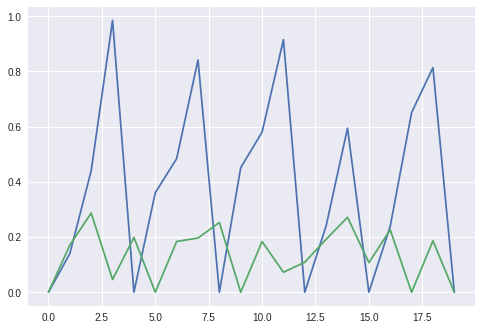

In [32]:
plt.plot(vals[:, 0, 0])
plt.plot(vals[:, 0, 3])

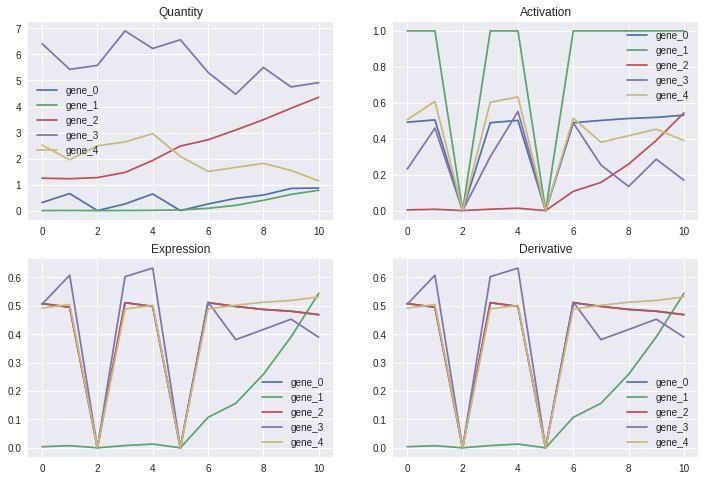

In [13]:
plt.figure(figsize=(12, 8))
for i, name in enumerate(["Quantity", "Activation", "Expression", "Derivative"]):
    plt.subplot(2, 2, i + 1)
    plt.title(name)
    plt.plot(vals[:, i, 0], label="gene_0")
    plt.plot(vals[:, i, 1], label="gene_1")
    plt.plot(vals[:, i, 2], label="gene_2")
    plt.plot(vals[:, i, 3], label="gene_3")
    plt.plot(vals[:, i, 4], label="gene_4")
    plt.legend()

In [14]:
best_sol.grn

>> G_0: init: 0.60; noise: 5.51; b: 9.34; m: 1.94; expr: 1.00; deg: 0.00; theta: 9.56; tree : NOT 0
>> G_1: init: 0.07; noise: 2.42; b: 8.81; m: 9.12; expr: 1.00; deg: 0.00; theta: 2.42; tree : 2
>> G_2: init: 1.10; noise: 2.78; b: 1.34; m: 7.12; expr: 1.00; deg: 0.00; theta: 5.15; tree : NOT 0
>> G_3: init: 2.91; noise: 7.81; b: 2.75; m: 7.14; expr: 1.00; deg: 0.00; theta: 9.38; tree : 4
>> G_4: init: 0.65; noise: 9.60; b: 6.52; m: 7.79; expr: 1.00; deg: 0.00; theta: 8.54; tree : 0

In [15]:
[len(x["population"]) for x in bb.snapshots.values()][:10]

[35, 33, 35, 28, 43, 35, 47, 42, 55, 32]

In [44]:
np.array(list(bb.snapshots[50.5]["population"].values()))[:5]

array([[4.4097948e+00, 3.1775782e-01, 6.8595737e-02, 4.7433871e-01,
        9.4855875e-02, 1.7770454e+00, 2.6563072e+00],
       [1.9393390e+00, 3.8325670e-01, 6.5536410e-02, 1.7372435e-01,
        2.8888218e-03, 1.7851083e+00, 2.0685969e-01],
       [1.0609788e+00, 5.0435525e-01, 3.0940732e-01, 4.3150026e-02,
        9.2866227e-02, 2.3256412e+00, 6.8733788e-01],
       [1.6642286e+00, 5.6442070e-01, 2.6851991e-02, 1.2357676e-01,
        6.7333784e-03, 9.8203927e-01, 1.6394301e-01],
       [4.9255476e+00, 3.1499872e-01, 2.5002247e-02, 4.8729381e-01,
        9.4887525e-02, 9.7402722e-01, 4.7069129e-01]], dtype=float32)

## Setup scanpy

In [38]:
def build_scanpy_dataset(bb):
    # export expressions
    vec_age = []
    vec_gene_quantity = []
    for age in bb.snapshots:
        for gene_quantity in bb.snapshots[age]["population"].values():
            vec_age.append(age)
            vec_gene_quantity.append(gene_quantity)

    n_obs = len(vec_age)
    id_cells = np.arange(n_obs, dtype=int).astype(str)
    
    # metadata
    id_genes = np.array([f"gene_{i}" for i in range(len(vec_gene_quantity[0]))])
    obs_meta = pd.DataFrame({
        "age": np.array(vec_age)
    }, index=id_cells)
    
    # build dataset
    df = pd.DataFrame(np.array(vec_gene_quantity), columns=id_genes, index=id_cells)
    dts = AnnData(df, obs=obs_meta)
    
    return dts

In [61]:
dts = build_scanpy_dataset(bb)

In [62]:
sp.pp.neighbors(dts)

In [63]:
sp.tl.umap(dts)

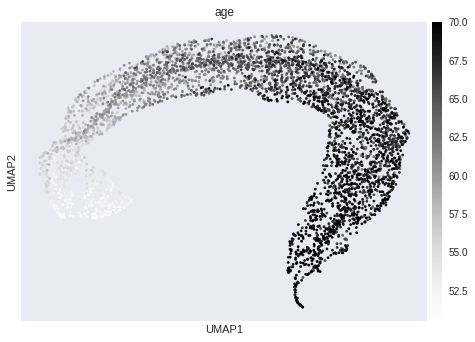

In [64]:
sp.pl.umap(dts, color="age")

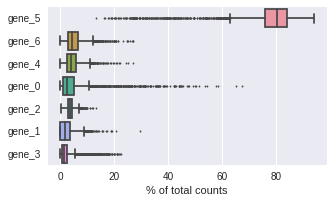

In [54]:
sp.pl.highest_expr_genes(dts, n_top = 7, save = True)

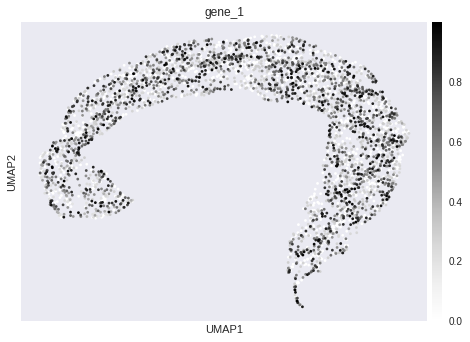

In [72]:
sp.pl.umap(dts, color="gene_1")